In [35]:
import numpy as np
import networkx as nx
from networkx.generators.community import LFR_benchmark_graph
from matplotlib import pyplot as plt
import itertools

from sklearn.metrics import normalized_mutual_info_score
import torch

from src.em import em_algorithm

%reload_ext autoreload
%autoreload 2

In [36]:
def rearrange_tau(q, true_classes_clusters, Q):
    # Rearrange q such that the number of misclassified nodes is minimized
    if isinstance(q, torch.Tensor):
        pred_clusters = np.argmax(q.detach().numpy(), axis=1)
    else:
        pred_clusters = np.argmax(q, axis=1)
    # Store all possible permutations of the classes
    permutations = list()
    for permutation in itertools.permutations(range(Q)):
        permutations.append(permutation)

    # Compute the number of misclassified nodes for each permutation
    misclassified_nodes = list()
    for permutation in permutations:
        misclassified_nodes.append(
            np.sum(pred_clusters != [permutation[i] for i in true_classes_clusters])
        )
    # Find the permutation that minimizes the number of misclassified nodes
    best_permutation = permutations[np.argmin(misclassified_nodes)]

    # Rearrange q according to the best permutation
    new_q = np.zeros_like(q)
    for i in range(Q):
        new_q[:, i] = q[:, best_permutation[i]]

    return new_q

# Karate Dataset

In [97]:
# Loads the karate network
G = nx.read_weighted_edgelist(
    "./data/karate.edgelist", delimiter=" ", nodetype=int, create_using=nx.Graph()
)
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt("./data/karate_labels.txt", delimiter=",", dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i, 0]] = class_labels[i, 1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)

X = nx.adjacency_matrix(G).todense()
X = np.array(X)

Number of nodes: 34
Number of edges: 78


In [98]:
alpha, pi, tau = em_algorithm(
    X, 2, implementation="pytorch", model="newman", n_init=10, iterations=100
)

After EM iteration 100/100 : Mean log likelihood (1 paths) -469.879751...


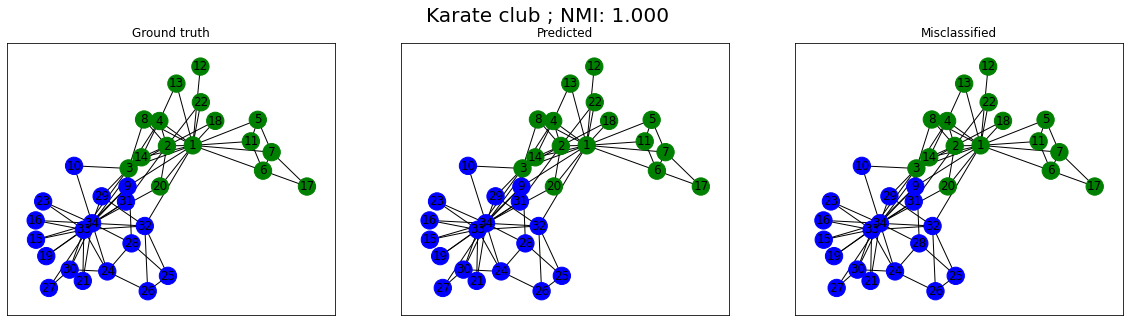

In [99]:
tau = rearrange_tau(tau, y, 2)

color_list = ["g", "b", "r"]
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle(
    "Karate club ; NMI: {:.3f}".format(
        normalized_mutual_info_score(y, np.argmax(tau, axis=1))
    ),
    fontsize=20,
)
fig.set_facecolor("w")
fig.valign = "center"
fig.halign = "center"
pos = nx.spring_layout(G, seed=42)
node_colors = [color_list[i] for i in y]
nx.draw_networkx(G, node_color=node_colors, ax=ax[0], pos=pos)
ax[0].set_title("Ground truth")
node_colors = np.argmax(tau, axis=1)
node_colors = [color_list[i] for i in node_colors]
nx.draw_networkx(G, node_color=node_colors, ax=ax[1], pos=pos)
ax[1].set_title("Predicted")
node_colors = np.argmax(tau, axis=1)
node_colors[node_colors != y] = 2
node_colors = [color_list[i] for i in node_colors]
nx.draw_networkx(G, node_color=node_colors, ax=ax[2], pos=pos)
ax[2].set_title("Misclassified")
plt.show()

# LFR Benchmarck

In [16]:
G = LFR_benchmark_graph(
    n=100,
    tau1=2,
    tau2=1.5,
    mu=0.1,
    average_degree=5,
    min_community=40,
    max_community=50,
    seed=10,
)
G.remove_edges_from(nx.selfloop_edges(G))

In [17]:
communities = {frozenset(G.nodes[v]["community"]) for v in G}
communities = [list(community) for community in communities]
communities = {node: i for i, community in enumerate(communities) for node in community}

colors = [
    "red",
    "blue",
    "green",
    "yellow",
    "orange",
    "purple",
    "black",
    "pink",
    "brown",
    "cyan",
]
nodes_colors = [colors[communities[node]] for node in G.nodes]

true_classes_clusters = [communities[node] for node in G.nodes]

In [20]:
X = nx.adjacency_matrix(G).todense()
X = np.array(X)
alpha, pi, tau = em_algorithm(
    X, 2, implementation="pytorch", model="newman", n_init=10, iterations=100
)

After EM iteration 100/100 : Mean log likelihood (1 paths) -1566.227858...


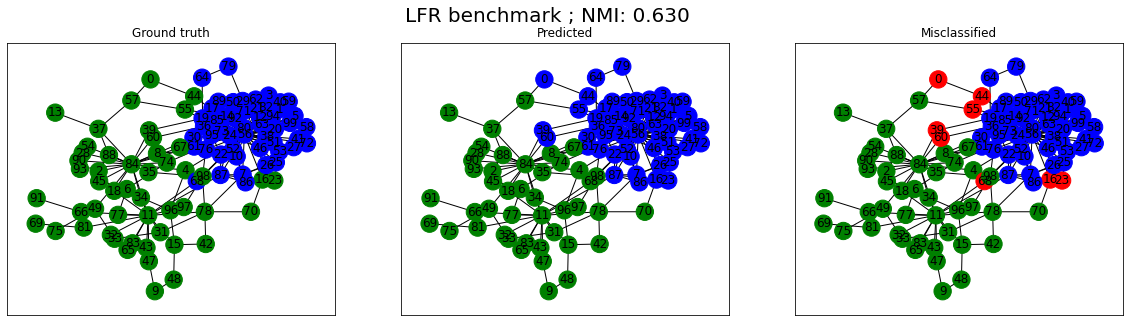

In [21]:
tau = rearrange_tau(tau, true_classes_clusters, 2)

pos = nx.spring_layout(G, seed=42)
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle(
    "LFR benchmark ; NMI: {:.3f}".format(
        normalized_mutual_info_score(true_classes_clusters, np.argmax(tau, axis=1))
    ),
    fontsize=20,
)
fig.set_facecolor("w")
fig.valign = "center"
fig.halign = "center"
node_colors = [color_list[i] for i in true_classes_clusters]
nx.draw_networkx(G, node_color=node_colors, ax=ax[0], pos=pos)
ax[0].set_title("Ground truth")
node_colors = np.argmax(tau, axis=1)
node_colors = [color_list[i] for i in node_colors]
nx.draw_networkx(G, node_color=node_colors, ax=ax[1], pos=pos)
ax[1].set_title("Predicted")
node_colors = np.argmax(tau, axis=1)
node_colors[node_colors != true_classes_clusters] = 2
node_colors = [color_list[i] for i in node_colors]
nx.draw_networkx(G, node_color=node_colors, ax=ax[2], pos=pos)
ax[2].set_title("Misclassified")
plt.show()

# Mixture model benchmark

## 2 clusters

In [22]:
from src.graphs import random_graph_from_parameters
from main import sort_parameters

In [23]:
# Test the algorithm on a random graph
Q = 2
n = 50
alpha = np.random.uniform(0, 0.8, Q)
alpha = alpha / np.sum(alpha)
pi = np.zeros((Q, Q))
# fill upper triangle with values between 0.1 and 0.3
for i in range(Q):
    for j in range(i + 1, Q):
        pi[i][j] = round(np.random.uniform(0.1, 0.5), 2)
# make pi symmetrical
for i in range(Q):
    for j in range(i):
        pi[i][j] = pi[j][i]
# random diagonal
for i in range(Q):
    pi[i][i] = round(np.random.uniform(0.7, 1), 2)

X, Z = random_graph_from_parameters(n, Q, alpha, pi)
true_classes_clusters = np.argmax(Z, axis=1)
alpha, pi = sort_parameters(alpha, pi)

G = nx.from_numpy_array(X)

In [24]:
X = nx.adjacency_matrix(G).todense()
X = np.array(X)
alpha, pi, tau = em_algorithm(
    X, 2, implementation="pytorch", model="newman", n_init=10, iterations=100
)

After EM iteration 100/100 : Mean log likelihood (1 paths) -5065.142009...


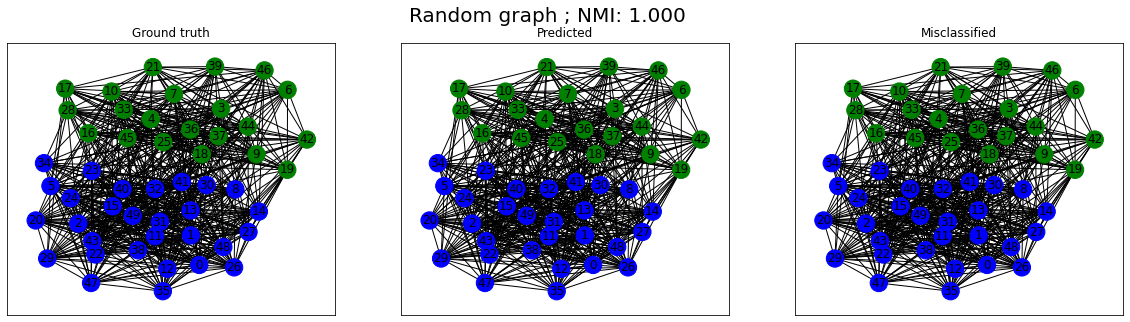

In [25]:
tau = rearrange_tau(tau, true_classes_clusters, 2)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle(
    "Random graph ; NMI: {:.3f}".format(
        normalized_mutual_info_score(true_classes_clusters, np.argmax(tau, axis=1))
    ),
    fontsize=20,
)
fig.set_facecolor("w")
fig.valign = "center"
fig.halign = "center"
pos = nx.spring_layout(G, seed=42)
node_colors = [color_list[i] for i in true_classes_clusters]
nx.draw_networkx(G, node_color=node_colors, ax=ax[0], pos=pos)
ax[0].set_title("Ground truth")
node_colors = np.argmax(tau, axis=1)
node_colors = [color_list[i] for i in node_colors]
nx.draw_networkx(G, node_color=node_colors, ax=ax[1], pos=pos)
ax[1].set_title("Predicted")
node_colors = np.argmax(tau, axis=1)
node_colors[node_colors != true_classes_clusters] = 2
node_colors = [color_list[i] for i in node_colors]
nx.draw_networkx(G, node_color=node_colors, ax=ax[2], pos=pos)
ax[2].set_title("Misclassified")
plt.show()

## 3 clusters

In [26]:
# Test the algorithm on a random graph
Q = 3
n = 100
alpha = np.random.uniform(0, 0.8, Q)
alpha = alpha / np.sum(alpha)
pi = np.zeros((Q, Q))
# fill upper triangle with values between 0.1 and 0.3
for i in range(Q):
    for j in range(i + 1, Q):
        pi[i][j] = round(np.random.uniform(0.1, 0.5), 2)
# make pi symmetrical
for i in range(Q):
    for j in range(i):
        pi[i][j] = pi[j][i]
# random diagonal
for i in range(Q):
    pi[i][i] = round(np.random.uniform(0.7, 1), 2)

X, Z = random_graph_from_parameters(n, Q, alpha, pi)
true_classes_clusters = np.argmax(Z, axis=1)
alpha, pi = sort_parameters(alpha, pi)

G = nx.from_numpy_array(X)

In [31]:
X = nx.adjacency_matrix(G).todense()
X = np.array(X)
alpha, pi, tau = em_algorithm(
    X, 3, implementation="pytorch", model="newman", n_init=10, iterations=100
)

After EM iteration 100/100 : Mean log likelihood (1 paths) -17609.263025...


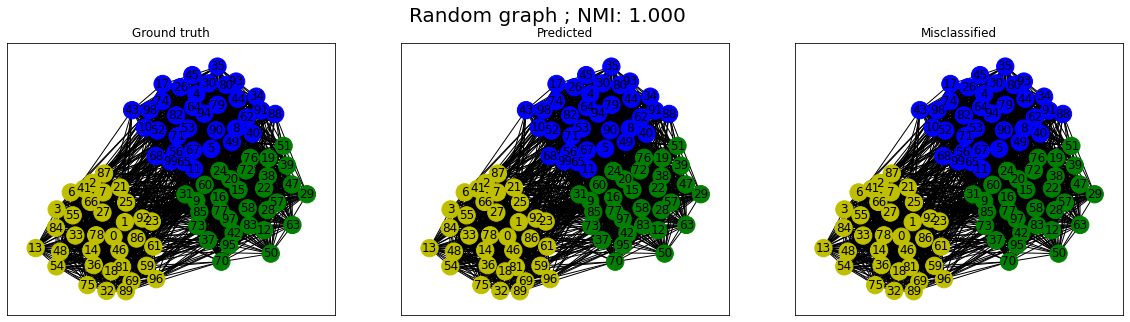

In [33]:
tau = rearrange_tau(tau, true_classes_clusters, Q)

color_list = ["g", "b", "y", "r"]
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle(
    "Random graph ; NMI: {:.3f}".format(
        normalized_mutual_info_score(true_classes_clusters, np.argmax(tau, axis=1))
    ),
    fontsize=20,
)
fig.set_facecolor("w")
fig.valign = "center"
fig.halign = "center"
pos = nx.spring_layout(G, seed=42)
node_colors = [color_list[i] for i in true_classes_clusters]
nx.draw_networkx(G, node_color=node_colors, ax=ax[0], pos=pos)
ax[0].set_title("Ground truth")
node_colors = np.argmax(tau, axis=1)
node_colors = [color_list[i] for i in node_colors]
nx.draw_networkx(G, node_color=node_colors, ax=ax[1], pos=pos)
ax[1].set_title("Predicted")
node_colors = np.argmax(tau, axis=1)
node_colors[node_colors != true_classes_clusters] = 3
node_colors = [color_list[i] for i in node_colors]
nx.draw_networkx(G, node_color=node_colors, ax=ax[2], pos=pos)
ax[2].set_title("Misclassified")
plt.show()

# Real-life dataset : Biology

In [4]:
from graspologic.plot import adjplot
import pandas as pd
import pickle

In [100]:
edges_data = "data/E-coli/Escherichia-coli_edge-list.txt"
labels_data = "data/E-coli/Escherichia-coli.txt"

# Nodes
with open(edges_data) as edgelist:
    nb_nodes = int(edgelist.readline().strip("Nb_nodes:"))
G = nx.Graph()
G.add_nodes_from(range(nb_nodes))

# Edges
with open(edges_data) as edgelist:
    partial_graph = nx.read_edgelist(edgelist)
for edge in partial_graph.edges():
    G.add_edge(int(edge[0]), int(edge[1]))

# Labels
with open(labels_data) as labels:
    labels = labels.readlines()[1:]
    labels = [label.strip() for label in labels]
    labels = np.array(labels)
assert len(labels) == len(G.nodes())
for i, label in enumerate(labels):
    G.nodes[i]["label"] = label

X = nx.adjacency_matrix(G).todense()

In [101]:
G.number_of_nodes(), G.number_of_edges()

(2389, 48156)

In [102]:
torch.set_default_dtype(
    torch.float64
)  # torch.float32 is not precise enough for our needs (nans show up)

In [103]:
torch.exp(torch.tensor(500))

tensor(1.4036e+217)

In [104]:
a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5, 6])
torch.stack((a, b), dim=1)

tensor([[1, 4],
        [2, 5],
        [3, 6]])

In [ ]:
Q = 21
alpha, pi, tau = em_algorithm(
    X, Q, n_init=1, iterations=10, implementation="pytorch_log"
)

In [145]:
Q = 21
alpha, pi, tau = em_algorithm(
    X, Q, n_init=50, iterations=1000, implementation="pytorch", model="newman"
)

After EM iteration 1000/1000 : Mean log likelihood (1 paths) -521159.795784...


In [146]:
with open("results/newman_EM/alpha.pkl", "wb") as f:
    pickle.dump(alpha, f)
with open("results/newman_EM/pi.pkl", "wb") as f:
    pickle.dump(pi, f)
with open("results/newman_EM/tau.pkl", "wb") as f:
    pickle.dump(tau, f)

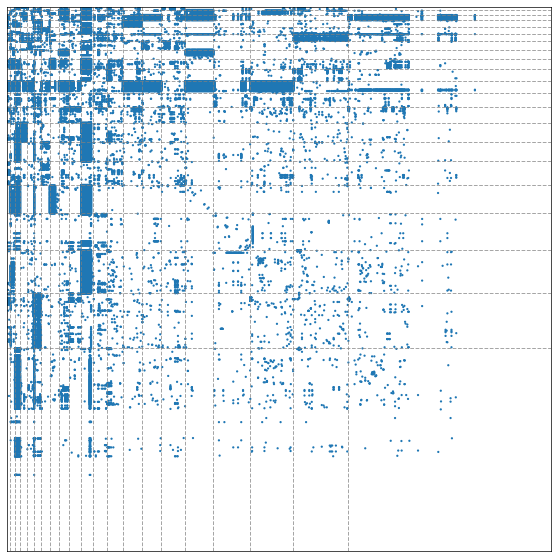

In [147]:
classification = tau.argmax(axis=1)

meta = pd.DataFrame(
    data={
        "Class": classification,
    },
)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
adjplot(data=X, ax=ax, meta=meta, plot_type="scattermap", group=["Class"], ticks=False)
plt.savefig("images/escheria-coli_newman.png")
plt.show()